In [32]:
!pip install tqdm -q
!pip install folium

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

In [34]:
# 한글 폰트 설정
import matplotlib
import matplotlib.font_manager as fm

# C:\Windows\Fonts   # ==> OS에 등록되어 있는 모든 폰트 파일들
font_path = 'C:\\Windows\\Fonts\\H2GTRM.TTF' # 윈도우 OS 폰트 경로

font_prop = fm.FontProperties(fname = font_path) # 폰트경로에 있는 폰트 이름들 뽑아오자.


font_name = font_prop.get_name() # 폰트명

#matplotlib.rc('font', key=value)
matplotlib.rc('font', family=font_name)

# matplotlib이 기본적으로 사용하는 유니코드 마이너스 비활성화
# -> 아스키코드의 마이너스 사용
plt.rc('axes', unicode_minus=False) # matplotlib의 기본적인 유니코드 minus폰트사용 중지

[ Dataset Info. ]
train.csv [파일] :
item_id : 무역품 식별 ID
year : 년
month : 월
seq : 동일 년-월 내 일련번호
type : 유형 구분 코드
hs4 : HS4 코드
weight : 중량
quantity : 수량
value : 무역량 (정수형)


sample_submission.csv [파일] - 제출 양식
leading_item_id : 선행 무역품 식별 ID
following_item_id : 후행 무역품 식별 ID
value : 2025년 8월의 후행 무역품에 예측된 총 무역량 (정수형)

In [35]:
train = pd.read_csv('train.csv')
train.head(3)

,item_id,year,month,seq,type,hs4,weight,quantity,value
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0


### 연도별 value 추이

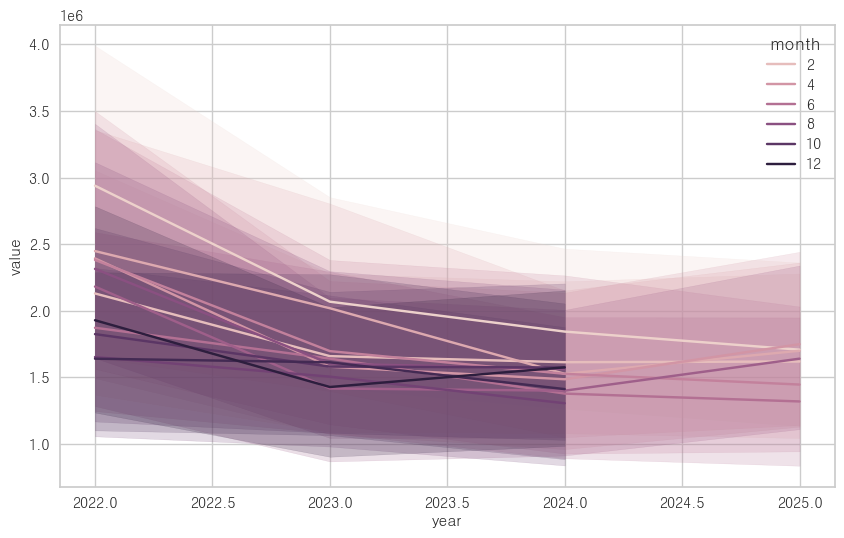

In [36]:
# 4년간 년도에 따라서 value가 어떻게 변했는지

fig = plt.figure(figsize=(10,6))
fig.set_facecolor('white')
sns.lineplot(data=train, x='year', y='value',
             hue='month')
plt.show()



### 4년간 월별 value 추이

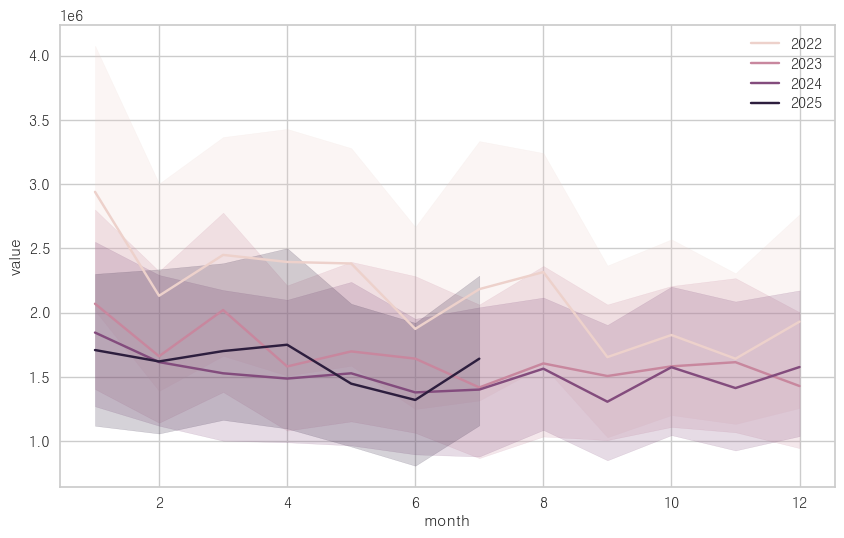

In [37]:
# 4년간 월에 따라서 value가 어떻게 변했는지

fig = plt.figure(figsize=(10,6))
fig.set_facecolor('white')
sns.lineplot(data=train, x='month', y='value',
            hue='year')
plt.legend()
plt.show()

### 월별 무역량

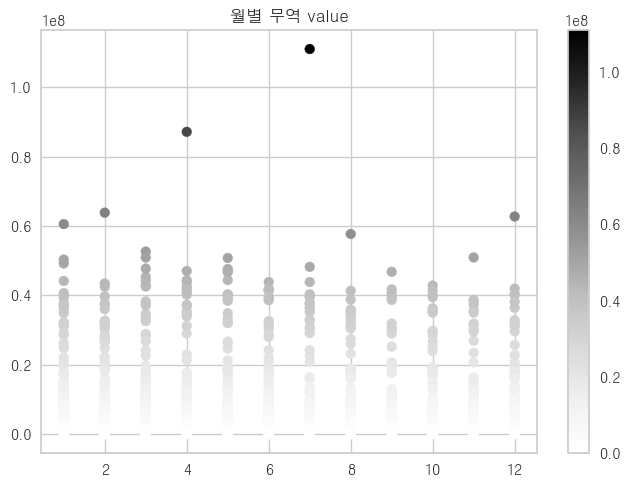

In [38]:
# 월별 무역량

plt.scatter(train['month'], train["value"],
            c=train['value'])
plt.title("월별 무역 value")
plt.colorbar()
plt.show()

### 월별 무역 횟수

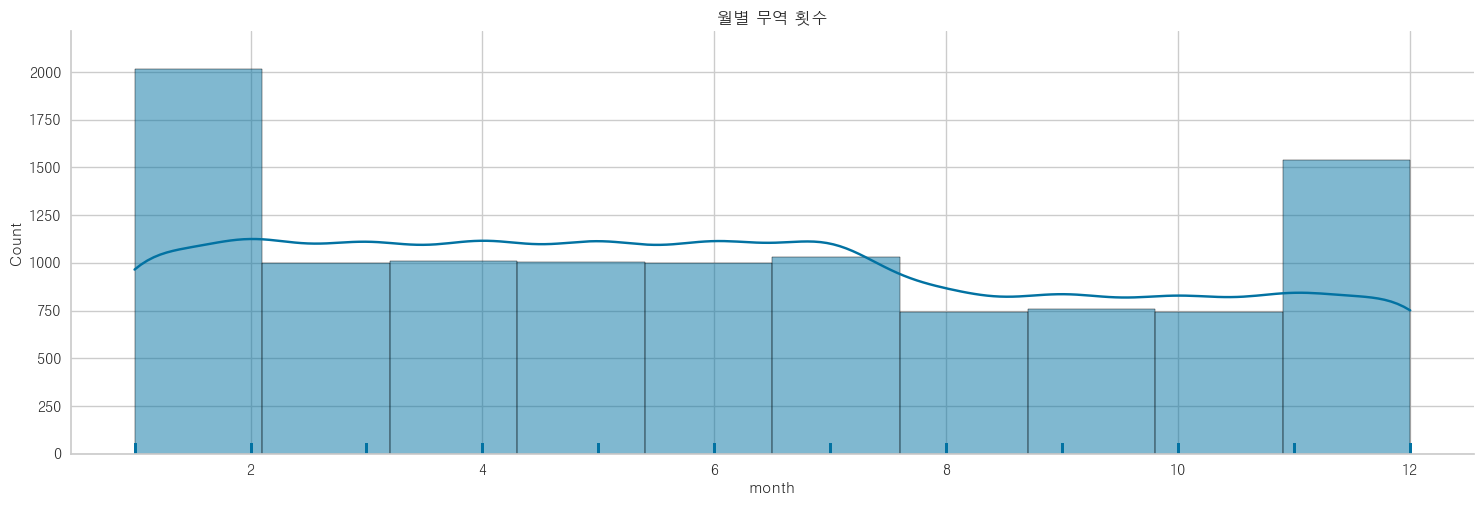

In [39]:
# 월별 무역 횟수
sns.displot(train["month"], bins=10, height=5,
            aspect=3, rug=True, kde=True)
plt.title("월별 무역 횟수")
plt.show()

### 무게와 무역량의 상관관계

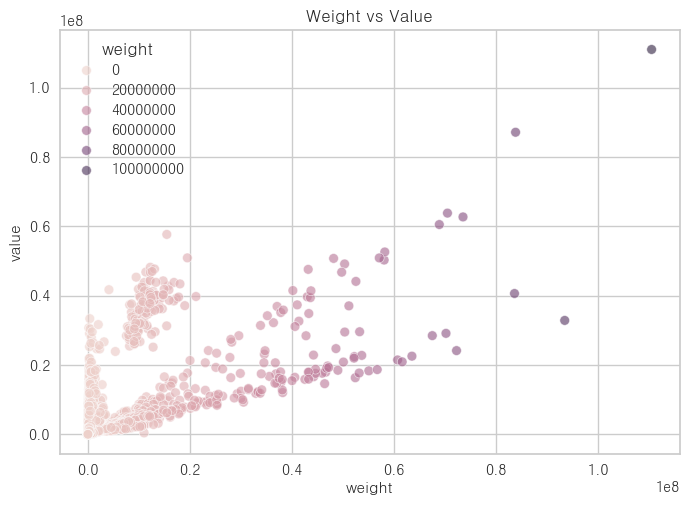

In [40]:
sns.scatterplot(data=train, x='weight', y='value', alpha=0.6, hue='weight')
plt.title("Weight vs Value")
plt.show()

### 년도별 무역량 상관관계

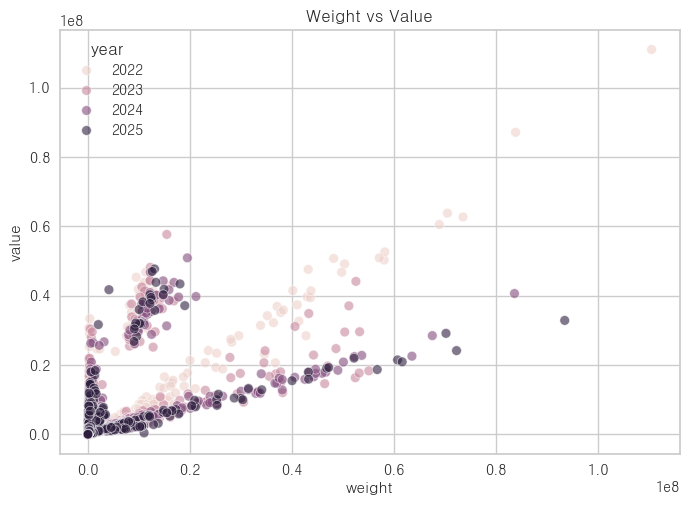

In [41]:
sns.scatterplot(data=train, x='weight', y='value', alpha=0.6, hue='year')
plt.title("Weight vs Value")
plt.show()

In [42]:
corr_mat = train.corr(numeric_only=True)
corr_mat

,year,month,seq,type,hs4,weight,quantity,value
year,1.000000,-0.191825,-0.001184,NaN,0.016171,-0.003075,-0.003065,-0.038326
month,-0.191825,1.000000,-0.000509,NaN,-0.002182,-0.017376,0.004954,-0.023048
seq,-0.001184,-0.000509,1.000000,NaN,-0.000828,0.009250,-0.012258,-0.000357
type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hs4,0.016171,-0.002182,-0.000828,NaN,1.000000,-0.117811,-0.001656,-0.016254
weight,-0.003075,-0.017376,0.009250,NaN,-0.117811,1.000000,-0.002299,0.670956
quantity,-0.003065,0.004954,-0.012258,NaN,-0.001656,-0.002299,1.000000,-0.000050
value,-0.038326,-0.023048,-0.000357,NaN,-0.016254,0.670956,-0.000050,1.000000


### weight/value 상관관계 heatmap

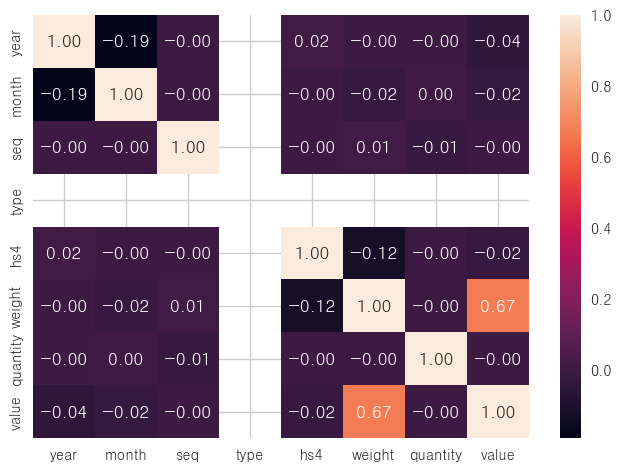

In [43]:
sns.heatmap(corr_mat, annot=True, fmt='.2f')
plt.show()

### 크롤링 하기 위해 unique한 hs4 값과 개수 

In [ ]:
# hs4 결측치 먼저 확인

name = pd.read_csv('hs4_code.csv')
t_ddf = name[name.isna().any(axis=1)]
t_ddf.groupby('hs4')['hs4'].size()

hs4
3024      5
3038    114
5119     96
7142      8
Name: hs4, dtype: int64

In [44]:
unique_hs4 = train["hs4"].dropna().unique()
print(sorted(unique_hs4))

print("고유 hs4 개수:", len(unique_hs4))
unique_hs4

[np.int64(1210), np.int64(2002), np.int64(2102), np.int64(2501), np.int64(2529), np.int64(2612), np.int64(2701), np.int64(2710), np.int64(2805), np.int64(2807), np.int64(2811), np.int64(2814), np.int64(2825), np.int64(2833), np.int64(2836), np.int64(2841), np.int64(2846), np.int64(2847), np.int64(2916), np.int64(3003), np.int64(3006), np.int64(3024), np.int64(3038), np.int64(3102), np.int64(3206), np.int64(3207), np.int64(3215), np.int64(3307), np.int64(3404), np.int64(3806), np.int64(3813), np.int64(3815), np.int64(3824), np.int64(3904), np.int64(3909), np.int64(4202), np.int64(4302), np.int64(4403), np.int64(4408), np.int64(4601), np.int64(4802), np.int64(4810), np.int64(5111), np.int64(5119), np.int64(5205), np.int64(5309), np.int64(5402), np.int64(5512), np.int64(5515), np.int64(5602), np.int64(5609), np.int64(5705), np.int64(6006), np.int64(6101), np.int64(6211), np.int64(7142), np.int64(7202), np.int64(7207), np.int64(7907), np.int64(8102), np.int64(8105), np.int64(8461), np.int6

array([3038, 2002, 2102, 2501, 2529, 2805, 2807, 2811, 2814, 2825, 2833,
       2836, 2841, 2846, 2847, 2916, 3006, 3102, 3206, 3207, 3215, 3307,
       3404, 3806, 3815, 3824, 3904, 3909, 4202, 4601, 4802, 5111, 5205,
       5309, 5402, 5515, 5602, 5609, 5705, 6101, 6211, 7202, 7207, 8102,
       8105, 8461, 8467, 8479, 8501, 8505, 8527, 8708, 8714, 9403, 1210,
       3813, 4408, 4810, 5512, 2701, 7907, 2710, 6006, 5119, 9022, 4403,
       3003, 2612, 4302, 7142, 3024])

In [45]:
hs4_list = train['hs4'].dropna().astype(int).unique().tolist()
# print(len(hs4_list))
hs4_list

[3038,
 2002,
 2102,
 2501,
 2529,
 2805,
 2807,
 2811,
 2814,
 2825,
 2833,
 2836,
 2841,
 2846,
 2847,
 2916,
 3006,
 3102,
 3206,
 3207,
 3215,
 3307,
 3404,
 3806,
 3815,
 3824,
 3904,
 3909,
 4202,
 4601,
 4802,
 5111,
 5205,
 5309,
 5402,
 5515,
 5602,
 5609,
 5705,
 6101,
 6211,
 7202,
 7207,
 8102,
 8105,
 8461,
 8467,
 8479,
 8501,
 8505,
 8527,
 8708,
 8714,
 9403,
 1210,
 3813,
 4408,
 4810,
 5512,
 2701,
 7907,
 2710,
 6006,
 5119,
 9022,
 4403,
 3003,
 2612,
 4302,
 7142,
 3024]

# Cluster

### 군집화를 위한 데이터 정규화
0-1 범위로 데이터 변환

In [46]:
from sklearn.preprocessing import MinMaxScaler
# 두 가지 feature를 대상
data = train[['weight', 'value']]

# 정규화 진행
scaler = MinMaxScaler()
data_scale = scaler.fit_transform(data)

data_scale

array([[1.34471397e-04, 2.94376737e-04],
       [5.62891946e-04, 9.96178155e-04],
       [1.66763357e-04, 6.55305239e-04],
       ...,
       [6.86023145e-06, 6.69813343e-04],
       [3.12240086e-06, 6.27874024e-04],
       [2.18569779e-02, 5.72694236e-02]], shape=(10836, 2))

### weight과 value의 원본 데이터 시각화

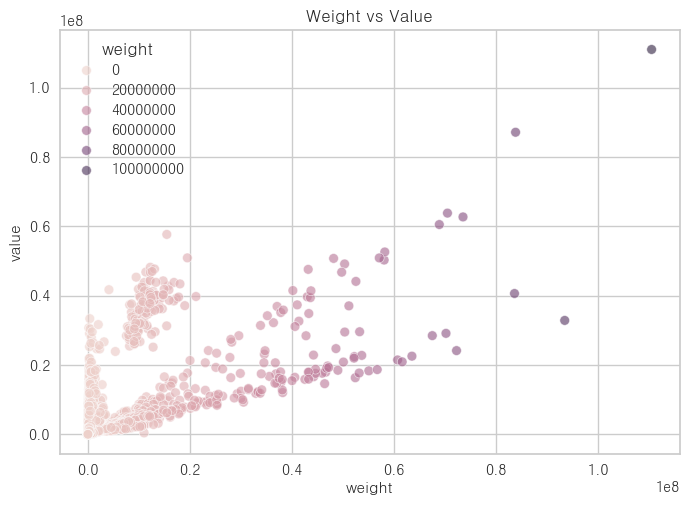

In [47]:
sns.scatterplot(data=train, x='weight', y='value', alpha=0.6, hue='weight')
plt.title("Weight vs Value")
plt.show()


### K-Means 군집화 수행
K-Means : 비슷한 특성을 가진 데이터들을 자동으로 K개의 그룹으로 나누는 군집화 알고리즘작동 원리

In [48]:
from sklearn.cluster import KMeans

k = 3

# 그룹 수, random_state 설정
model = KMeans(n_clusters = k, random_state = 10)

# 정규화된 데이터에 학습
model.fit(data_scale)

# 클러스터링 결과 각 데이터가 몇 번째 그룹에 속하는지 저장
train['cluster'] = model.fit_predict(data_scale)

### K-means 군집 시각화

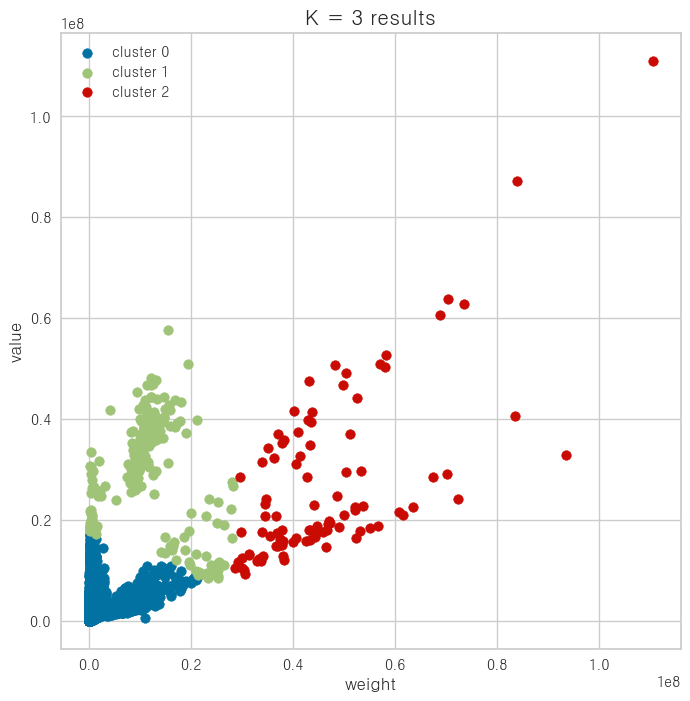

In [49]:
import matplotlib.pyplot as plt

plt.figure(figsize = (8, 8))

for i in range(k):
    plt.scatter(train.loc[train['cluster'] == i, 'weight'], train.loc[train['cluster'] == i, 'value'], 
                label = 'cluster ' + str(i))

plt.legend()
plt.title('K = %d results'%k , size = 15)
plt.xlabel('weight', size = 12)
plt.ylabel('value', size = 12)
plt.show()

In [50]:
!pip install yellowbrick

### 군집이 적절한 개수 찾기

,estimator,KMeans(n_clusters=9)
,ax,<Axes: >
,k,"(1, ...)"
,metric,'distortion'
,distance_metric,'euclidean'
,timings,True
,locate_elbow,True
,n_clusters,9
,init,'k-means++'
,n_init,'auto'
,max_iter,300


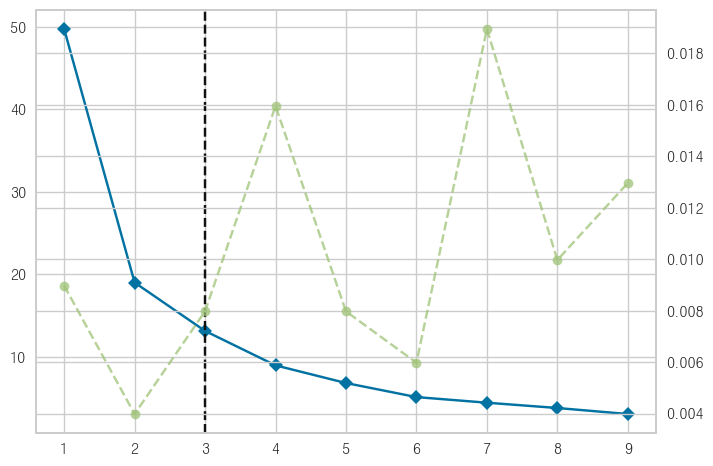

In [51]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10))
visualizer.fit(data_scale)

### hs4코드 매칭 크롤링하기 위한 데이터 확인

In [52]:
unique_hs4 = train["hs4"].dropna().unique()
print(sorted(unique_hs4))

print("고유 hs4 개수:", len(unique_hs4))
unique_hs4

[np.int64(1210), np.int64(2002), np.int64(2102), np.int64(2501), np.int64(2529), np.int64(2612), np.int64(2701), np.int64(2710), np.int64(2805), np.int64(2807), np.int64(2811), np.int64(2814), np.int64(2825), np.int64(2833), np.int64(2836), np.int64(2841), np.int64(2846), np.int64(2847), np.int64(2916), np.int64(3003), np.int64(3006), np.int64(3024), np.int64(3038), np.int64(3102), np.int64(3206), np.int64(3207), np.int64(3215), np.int64(3307), np.int64(3404), np.int64(3806), np.int64(3813), np.int64(3815), np.int64(3824), np.int64(3904), np.int64(3909), np.int64(4202), np.int64(4302), np.int64(4403), np.int64(4408), np.int64(4601), np.int64(4802), np.int64(4810), np.int64(5111), np.int64(5119), np.int64(5205), np.int64(5309), np.int64(5402), np.int64(5512), np.int64(5515), np.int64(5602), np.int64(5609), np.int64(5705), np.int64(6006), np.int64(6101), np.int64(6211), np.int64(7142), np.int64(7202), np.int64(7207), np.int64(7907), np.int64(8102), np.int64(8105), np.int64(8461), np.int6

array([3038, 2002, 2102, 2501, 2529, 2805, 2807, 2811, 2814, 2825, 2833,
       2836, 2841, 2846, 2847, 2916, 3006, 3102, 3206, 3207, 3215, 3307,
       3404, 3806, 3815, 3824, 3904, 3909, 4202, 4601, 4802, 5111, 5205,
       5309, 5402, 5515, 5602, 5609, 5705, 6101, 6211, 7202, 7207, 8102,
       8105, 8461, 8467, 8479, 8501, 8505, 8527, 8708, 8714, 9403, 1210,
       3813, 4408, 4810, 5512, 2701, 7907, 2710, 6006, 5119, 9022, 4403,
       3003, 2612, 4302, 7142, 3024])

### 조건별 군집 분류 3개

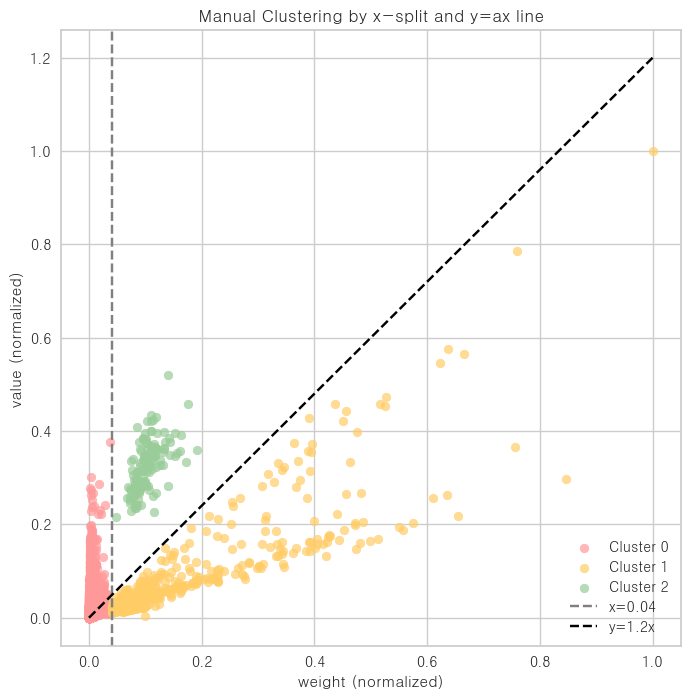

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# 최대 weight 값 기준 정규화 (0~1 범위로 맞추면 시각화 깔끔)
x = train['weight'] / train['weight'].max()
y = train['value'] / train['value'].max()

# 기준선 설정
x_split = 0.04     # x=0.3 경계선
a = 1.2            # y = a*x 기준선 (기울기)
train['cluster_manual'] = 0  # 기본값

# 조건별 군집 분류
train.loc[(x <= x_split), 'cluster_manual'] = 0 # 분홍색 군집
train.loc[(x > x_split) & (y < a * x), 'cluster_manual'] = 1 # 노란색 군집
train.loc[(x > x_split) & (y >= a * x), 'cluster_manual'] = 2 # 초록색 군집



############################################################################
# 시각화
plt.figure(figsize=(8,8))
colors = ['#FF9999','#FFCC66','#99CC99']
for i, color in enumerate(colors):
    plt.scatter(x[train['cluster_manual']==i],
                y[train['cluster_manual']==i],
                label=f'Cluster {i}', s=40, color=color, alpha=0.7)


# 기준선들 시각화
plt.axvline(x=x_split, color='gray', linestyle='--', label=f'x={x_split}')
plt.plot(np.linspace(0,1,100),
         a * np.linspace(0,1,100),
         color='black', linestyle='--', label=f'y={a}x')

plt.xlabel('weight (normalized)')
plt.ylabel('value (normalized)')
plt.title('Manual Clustering by x-split and y=ax line')
plt.legend()
plt.show()


In [54]:
hs4_code = pd.read_csv('./hs4_code.csv')
hs4_code.head(3)

,item_id,year,month,seq,type,hs4,weight,quantity,value,hs4_name
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0,NaN
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0,조제.보존처리한 토마토
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0,"효모, 단세포 미생물(죽은것), 베이킹 파우더 (조제한 것)"


### 조건별 군집 분류 4개

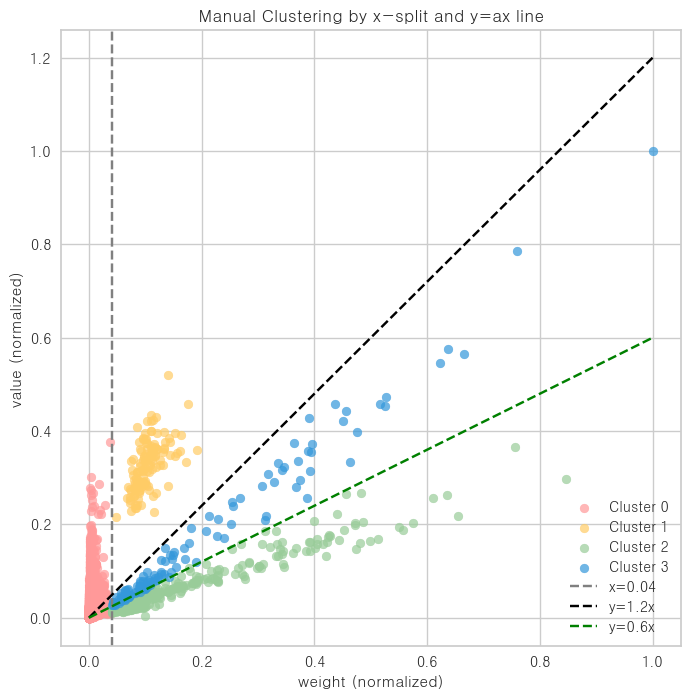

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# 최대 weight 값 기준 정규화 (0~1 범위로 맞추면 시각화 깔끔)
x = hs4_code['weight'] / hs4_code['weight'].max()
y = hs4_code['value'] / hs4_code['value'].max()

# 기준선 설정
x_split = 0.04     # x=0.3 경계선
a = 1.2            # y = a*x 기준선 (기울기)
b = 0.6            # y = b*x 기준선 (기울기)
hs4_code['cluster_manual'] = 0  # 기본값


#plt.imshow((x > x_split) & (y > a * x))



# 조건별 군집 분류
hs4_code.loc[(x <= x_split), 'cluster_manual'] = 0 # 분홍색 군집
hs4_code.loc[(x > x_split) & (y > a * x), 'cluster_manual'] = 1 # 노란색 군집
hs4_code.loc[(x > x_split) & (y <= a * x), 'cluster_manual'] = 2 # 초록색 군집
hs4_code.loc[(x > x_split) & (y <= a * x) & (y >= b * x), 'cluster_manual'] = 3 # 파란색 군집
############################################################################
# 시각화
plt.figure(figsize=(8,8))
colors = ['#FF9999','#FFCC66','#99CC99', '#3498db']
for i, color in enumerate(colors):
    plt.scatter(x[hs4_code['cluster_manual']==i],
                y[hs4_code['cluster_manual']==i],
                label=f'Cluster {i}', s=40, color=color, alpha=0.7)


# 기준선들 시각화
plt.axvline(x=x_split, color='gray', linestyle='--', label=f'x={x_split}')
plt.plot(np.linspace(0,1,100),
         a * np.linspace(0,1,100),
         color='black', linestyle='--', label=f'y={a}x')
plt.plot(np.linspace(0,1,100),
         b * np.linspace(0,1,100),
         color='green', linestyle='--', label=f'y={b}x')

plt.xlabel('weight (normalized)')
plt.ylabel('value (normalized)')
plt.title('Manual Clustering by x-split and y=ax line')
plt.legend()
plt.show()


### 군집 확인

In [56]:
print(hs4_code['cluster_manual'].unique())

[0 3 2 1]


### train_fe에 기존 csv 복사

In [57]:
train_fe = hs4_code.copy()
train_fe.head()

,item_id,year,month,seq,type,hs4,weight,quantity,value,hs4_name,cluster_manual
0,DEWLVASR,2022,1,1.0,1,3038,14858.0,0.0,32688.0,NaN,0
1,ELQGMQWE,2022,1,1.0,1,2002,62195.0,0.0,110617.0,조제.보존처리한 토마토,0
2,AHMDUILJ,2022,1,1.0,1,2102,18426.0,0.0,72766.0,"효모, 단세포 미생물(죽은것), 베이킹 파우더 (조제한 것)",0
3,XIPPENFQ,2022,1,1.0,1,2501,20426.0,0.0,11172.0,"소금, 순염화나트륨, 바닷물",0
4,FTSVTTSR,2022,1,1.0,1,2529,248000.0,0.0,143004.0,"장석, 백류석, 하석, 하석 섬장암, 형석",0


### 군집에 어떠한 item 있는지 확인

In [58]:
# seq_pivot_df_cnt = pd.pivot_table(train, index='item_id', columns="month", values='seq',aggfunc='count', margins=True, margins_name="seq_total")

# tmp_ser = seq_pivot_df_cnt['seq_total'].iloc[:-1]
# dct_seq_total = pd.cut(tmp_ser, bins= [0, 40, 80, tmp_ser.max()], labels = ['seq_cnt_low',  'seq_cnt_mid',  'seq_cnt_high'] ).to_dict()
# dct_seq_total

# train_fe = train.copy()
# train_fe['seq_cat'] = train_fe["item_id"].map(dct_seq_total)
# train_fe

tmp_df_seq = train_fe.groupby(["cluster_manual"], as_index=False)["item_id"].apply(lambda x: np.unique(x))
tmp_df_seq['cluster_manual_len'] = train_fe.groupby(["cluster_manual"])["item_id"].apply(lambda x: len(np.unique(x))).values#['item_id']#.sort_values(by='item_id', ascending=False, key = lambda x: len(x), axis=1)#.reset_index(drop=True)['item_id']
tmp_df_seq

dct_seq_cat = tmp_df_seq[['cluster_manual','item_id']].set_index('cluster_manual').to_dict()['item_id']
dct_seq_cat


{0: array(['AANGBULD', 'AHMDUILJ', 'ANWUJOKX', 'APQGTRMF', 'ATLDMDBO',
        'AXULOHBQ', 'BEZYMBBT', 'BJALXPFS', 'BLANHGYY', 'BSRMSVTC',
        'BTMOEMEP', 'BUZIIBYG', 'CCLHWFWF', 'DBWLZWNK', 'DDEXPPXU',
        'DEWLVASR', 'DJBLNPNC', 'DNMPSKTB', 'DUCMGGNW', 'ELQGMQWE',
        'EVBVXETX', 'FDXPMYGF', 'FITUEHWN', 'FQCLOEXA', 'FRHNWLNI',
        'FTSVTTSR', 'FWUCPMMW', 'GIKPEWTY', 'GKQIJYDH', 'GMBFCMIU',
        'GYHKIVQT', 'HCDTGMST', 'HXYSSRXE', 'IGDVVKUD', 'JBVHSUWY',
        'JERHKLYW', 'JPBRUTWP', 'JSLXRQOK', 'KAGJCHMR', 'KEUWZRKO',
        'KFQSHBNH', 'KJNSOAHR', 'LLHREMKS', 'LPHPPJUG', 'LRVGFDFM',
        'LSOIUSXD', 'LTOYKIML', 'LUENUFGA', 'MBSBZBXA', 'MIRCVAMV',
        'NAQIHUKZ', 'NZKBIBNU', 'OGAFEHLU', 'OJIFIHMZ', 'OKMBFVKS',
        'OXKURKXR', 'PLMZALFA', 'PYZMVUWD', 'QJQJSWFU', 'QKXNTIIB',
        'QRKRBYJL', 'QSDCUCLB', 'QVLMOEYE', 'RAWUKQMJ', 'RCBZUSIM',
        'RJCAXSGH', 'RJGPVEXX', 'ROACSLMG', 'RUVXNNVA', 'SAAYMURU',
        'SAHWCZNH', 'SDWAYPIK', 'SNHYOVBM', '

### 군집별 길이 출력

In [59]:
len(set(dct_seq_cat[0])), len(set(dct_seq_cat[1])), len(set(dct_seq_cat[2])), len(set(dct_seq_cat[3]))

(99, 1, 7, 4)

### 두 집합의 교집합이 되는 값 출력

In [60]:
print(set(dct_seq_cat[0]).intersection(set(dct_seq_cat[1]))) # 중복
print(set(dct_seq_cat[0]).intersection(set(dct_seq_cat[2])))
print(set(dct_seq_cat[1]).intersection(set(dct_seq_cat[2])))
print(set(dct_seq_cat[0]).intersection(set(dct_seq_cat[3])))
print(set(dct_seq_cat[1]).intersection(set(dct_seq_cat[3])))
print(set(dct_seq_cat[2]).intersection(set(dct_seq_cat[3])))



set()
{'HXYSSRXE', 'SDWAYPIK', 'BTMOEMEP', 'ATLDMDBO', 'LRVGFDFM', 'LLHREMKS', 'XMKRPGLB'}
set()
{'LRVGFDFM', 'ATLDMDBO', 'BTMOEMEP', 'SDWAYPIK'}
set()
{'LRVGFDFM', 'ATLDMDBO', 'BTMOEMEP', 'SDWAYPIK'}


### 새 변수에 담음

In [61]:
topN_seq_cat = tmp_df_seq['cluster_manual'].values
topN_seq_cat

array([0, 1, 2, 3])

### 월별 데이터 집계 및 피벗

In [62]:
train = pd.read_csv('train.csv')

# year, month, item_id 기준으로 value 합산 (seq만 다르다면 value 합산)
monthly = (
    train
    .groupby(["item_id", "year", "month"], as_index=False)["value"]
    .sum()
)

# year, month를 하나의 키(ym)로 묶기
monthly["ym"] = pd.to_datetime(
    monthly["year"].astype(str) + "-" + monthly["month"].astype(str).str.zfill(2)
)

# item_id × ym 피벗 (월별 총 무역량 매트릭스 생성)
pivot = (
    monthly
    .pivot(index="item_id", columns="ym", values="value")
    .fillna(0.0)
)

pivot.head()

ym,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,...,2024-10-01,2024-11-01,2024-12-01,2025-01-01,2025-02-01,2025-03-01,2025-04-01,2025-05-01,2025-06-01,2025-07-01
item_id,,,,,,,,,,,,,,,,,,,,,
AANGBULD,14276.0,52347.0,53549.0,0.0,26997.0,84489.0,0.0,0.0,0.0,0.0,...,428725.0,144248.0,26507.0,25691.0,25805.0,0.0,38441.0,0.0,441275.0,533478.0
AHMDUILJ,242705.0,120847.0,197317.0,126142.0,71730.0,149138.0,186617.0,169995.0,140547.0,89292.0,...,123085.0,143451.0,78649.0,125098.0,80404.0,157401.0,115509.0,127473.0,89479.0,101317.0
ANWUJOKX,0.0,0.0,0.0,63580.0,81670.0,26424.0,8470.0,0.0,0.0,80475.0,...,0.0,0.0,0.0,27980.0,0.0,0.0,0.0,0.0,0.0,0.0
APQGTRMF,383999.0,512813.0,217064.0,470398.0,539873.0,582317.0,759980.0,216019.0,537693.0,205326.0,...,683581.0,2147.0,0.0,25013.0,77.0,20741.0,2403.0,3543.0,32430.0,40608.0
ATLDMDBO,143097177.0,103568323.0,118403737.0,121873741.0,115024617.0,65716075.0,146216818.0,97552978.0,72341427.0,87454167.0,...,60276050.0,30160198.0,42613728.0,64451013.0,38667429.0,29354408.0,42450439.0,37136720.0,32181798.0,57090235.0


### 클러스터별 품목 시계열 패턴 분석

top1_seq_cat=0, 99개 아이템, ['AANGBULD' 'AHMDUILJ' 'ANWUJOKX' 'APQGTRMF' 'ATLDMDBO' 'AXULOHBQ'
 'BEZYMBBT' 'BJALXPFS' 'BLANHGYY' 'BSRMSVTC' 'BTMOEMEP' 'BUZIIBYG'
 'CCLHWFWF' 'DBWLZWNK' 'DDEXPPXU' 'DEWLVASR' 'DJBLNPNC' 'DNMPSKTB'
 'DUCMGGNW' 'ELQGMQWE' 'EVBVXETX' 'FDXPMYGF' 'FITUEHWN' 'FQCLOEXA'
 'FRHNWLNI' 'FTSVTTSR' 'FWUCPMMW' 'GIKPEWTY' 'GKQIJYDH' 'GMBFCMIU'
 'GYHKIVQT' 'HCDTGMST' 'HXYSSRXE' 'IGDVVKUD' 'JBVHSUWY' 'JERHKLYW'
 'JPBRUTWP' 'JSLXRQOK' 'KAGJCHMR' 'KEUWZRKO' 'KFQSHBNH' 'KJNSOAHR'
 'LLHREMKS' 'LPHPPJUG' 'LRVGFDFM' 'LSOIUSXD' 'LTOYKIML' 'LUENUFGA'
 'MBSBZBXA' 'MIRCVAMV' 'NAQIHUKZ' 'NZKBIBNU' 'OGAFEHLU' 'OJIFIHMZ'
 'OKMBFVKS' 'OXKURKXR' 'PLMZALFA' 'PYZMVUWD' 'QJQJSWFU' 'QKXNTIIB'
 'QRKRBYJL' 'QSDCUCLB' 'QVLMOEYE' 'RAWUKQMJ' 'RCBZUSIM' 'RJCAXSGH'
 'RJGPVEXX' 'ROACSLMG' 'RUVXNNVA' 'SAAYMURU' 'SAHWCZNH' 'SDWAYPIK'
 'SNHYOVBM' 'STZDBITS' 'SUOYXCHP' 'TANNMIMB' 'TGOELCAG' 'UGEQLMXM'
 'UIFPPCLR' 'UQYUIVVR' 'UXSPKBJR' 'VBYCLTYZ' 'VMAQSTJE' 'VUAFAIYJ'
 'VWMBASNE' 'WBLJNPZQ' 'WHPUAOID' 'WP

<Axes: xlabel='item_id', ylabel='item_id'>

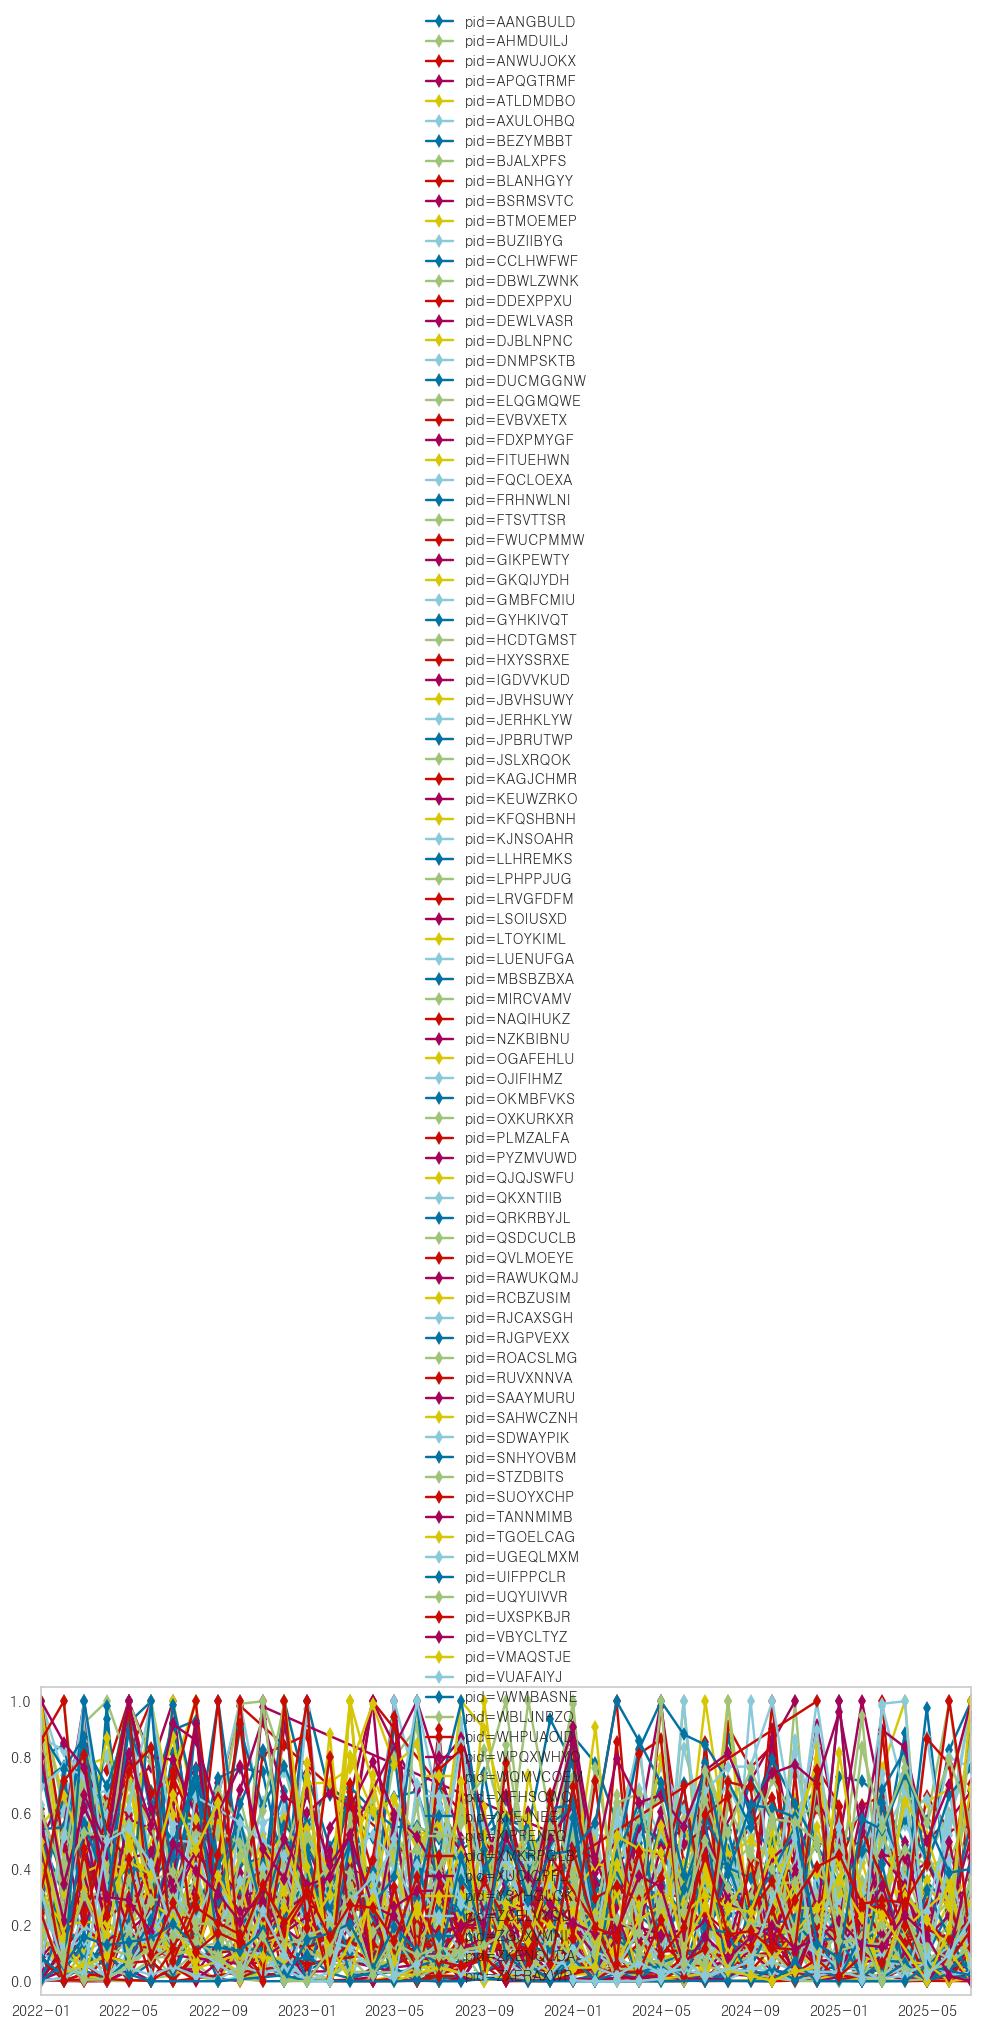

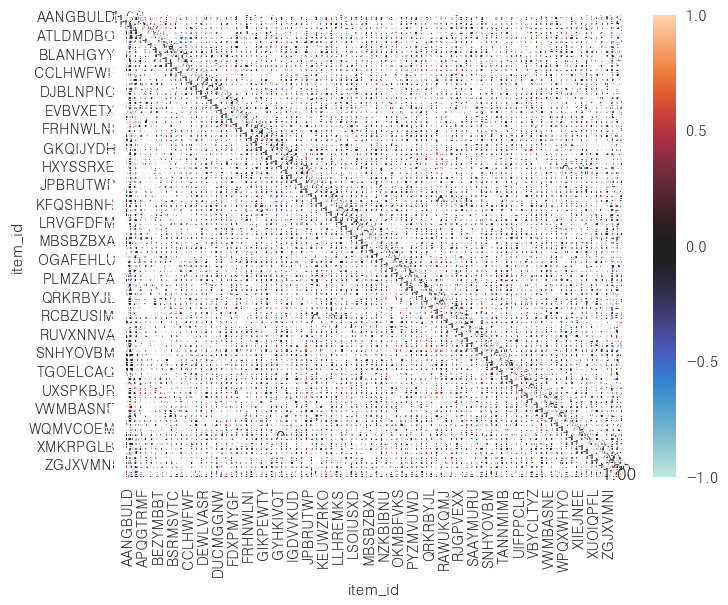

In [63]:
### sel_topN_seq_cat = 1 경우
### 

sel_topN_seq_cat = 1
print(f'top{sel_topN_seq_cat}_seq_cat={topN_seq_cat[sel_topN_seq_cat-1]}, {len(dct_seq_cat[topN_seq_cat[sel_topN_seq_cat-1]])}개 아이템, {dct_seq_cat[topN_seq_cat[sel_topN_seq_cat-1]]}') # top1_hs4 : ['BSRMSVTC' 'DJBLNPNC' 'RCBZUSIM' 'SUOYXCHP' 'WQMVCOEM' 'ZKENOUDA']

df_hm_plot = pd.DataFrame()
j= 0
fig = plt.figure(figsize=(12,4))
for i, group in enumerate(monthly.groupby("item_id")[['item_id','ym', 'value']]):
    if group[0] in dct_seq_cat[topN_seq_cat[sel_topN_seq_cat-1]]:
        j += 1
        #print(f'i = {i}, group name: {group[0]}, df_group: {group[1].head(1)}')
        print(f'index = {i+1}, {j}th item, item name: {group[0]}')

        df_hm_plot = pd.concat([df_hm_plot, group[1]], axis=0)

        ax = plt.gca()
        # 상품별 월별 무역량(월 최대 3회 교역)
        #ax.plot(group[1]["ym"], group[1]["value"], label=f'pid={group[0]}', marker='d')
        #ax.plot(group[1]["ym"], group[1]["value"]/group[1]["value"].max(), label=f'pid={group[0]}', marker='d')
        ax.plot(group[1]["ym"], (group[1]["value"]- group[1]["value"].min())/(group[1]["value"].max()- group[1]["value"].min()), label=f'pid={group[0]}', marker='d')

        ax.set_xlim([monthly['ym'].min(), monthly['ym'].max()])
        ax.legend()
        ax.grid()
        
        #if i==5: break
    
#display(df_hm_plot)
fig_sns = plt.figure(figsize=(8,6))
corr_mat= pd.pivot_table(df_hm_plot, index='ym', columns='item_id', values='value', fill_value=0).corr()
sns.heatmap(corr_mat, annot=True, fmt=".2f",vmin=-1, vmax=1, cbar_kws={'ticks': [-1, -0.5, 0, 0.5, 1]}, center=0 )




### 높은 상관관계를 가진 것만 출력 (0.7 이상)

In [64]:
#///////////////////////////////////////////////////////////////
# 높은 상관관계를 가진 것만 출력
high_corr = []
for i, row in enumerate(corr_mat[(corr_mat.abs() > 0.7) & corr_mat[(corr_mat.abs() < 0.99)]].iterrows()):
    if row[1].any():
        print(( row[1][row[1].notna()].name, row[1][row[1].notna()].index.to_list()))
        high_corr.append((row[1][row[1].notna()].name, row[1][row[1].notna()].index.to_list()))


('ATLDMDBO', ['DNMPSKTB', 'QRKRBYJL', 'XUOIQPFL'])
('DNMPSKTB', ['ATLDMDBO', 'XUOIQPFL'])
('IGDVVKUD', ['XIIEJNEE'])
('KFQSHBNH', ['RJCAXSGH'])
('QRKRBYJL', ['ATLDMDBO', 'QVLMOEYE', 'SDWAYPIK', 'VBYCLTYZ'])
('QVLMOEYE', ['QRKRBYJL', 'VBYCLTYZ'])
('RJCAXSGH', ['KFQSHBNH'])
('SDWAYPIK', ['QRKRBYJL'])
('UGEQLMXM', ['XIIEJNEE'])
('VBYCLTYZ', ['QRKRBYJL', 'QVLMOEYE'])
('XIIEJNEE', ['IGDVVKUD', 'UGEQLMXM'])
('XUOIQPFL', ['ATLDMDBO', 'DNMPSKTB'])


In [65]:
dict_hight_corr = dict(high_corr)
dict_hight_corr


{'ATLDMDBO': ['DNMPSKTB', 'QRKRBYJL', 'XUOIQPFL'],
 'DNMPSKTB': ['ATLDMDBO', 'XUOIQPFL'],
 'IGDVVKUD': ['XIIEJNEE'],
 'KFQSHBNH': ['RJCAXSGH'],
 'QRKRBYJL': ['ATLDMDBO', 'QVLMOEYE', 'SDWAYPIK', 'VBYCLTYZ'],
 'QVLMOEYE': ['QRKRBYJL', 'VBYCLTYZ'],
 'RJCAXSGH': ['KFQSHBNH'],
 'SDWAYPIK': ['QRKRBYJL'],
 'UGEQLMXM': ['XIIEJNEE'],
 'VBYCLTYZ': ['QRKRBYJL', 'QVLMOEYE'],
 'XIIEJNEE': ['IGDVVKUD', 'UGEQLMXM'],
 'XUOIQPFL': ['ATLDMDBO', 'DNMPSKTB']}

### 상관관계 높은 품목 패턴 시각화

index = 1, item, item name: ATLDMDBO : ['DNMPSKTB', 'QRKRBYJL', 'XUOIQPFL']
index = 2, item, item name: DNMPSKTB : ['ATLDMDBO', 'XUOIQPFL']
index = 3, item, item name: IGDVVKUD : ['XIIEJNEE']
index = 4, item, item name: KFQSHBNH : ['RJCAXSGH']
index = 5, item, item name: QRKRBYJL : ['ATLDMDBO', 'QVLMOEYE', 'SDWAYPIK', 'VBYCLTYZ']
index = 6, item, item name: QVLMOEYE : ['QRKRBYJL', 'VBYCLTYZ']
index = 7, item, item name: RJCAXSGH : ['KFQSHBNH']
index = 8, item, item name: SDWAYPIK : ['QRKRBYJL']
index = 9, item, item name: UGEQLMXM : ['XIIEJNEE']
index = 10, item, item name: VBYCLTYZ : ['QRKRBYJL', 'QVLMOEYE']
index = 11, item, item name: XIIEJNEE : ['IGDVVKUD', 'UGEQLMXM']


C:\Users\TJ\AppData\Local\Temp\ipykernel_8096\1504879425.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(12,4))


index = 12, item, item name: XUOIQPFL : ['ATLDMDBO', 'DNMPSKTB']


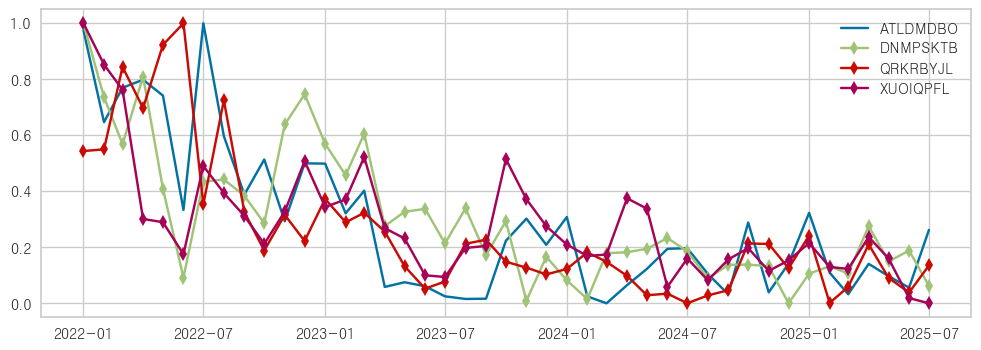

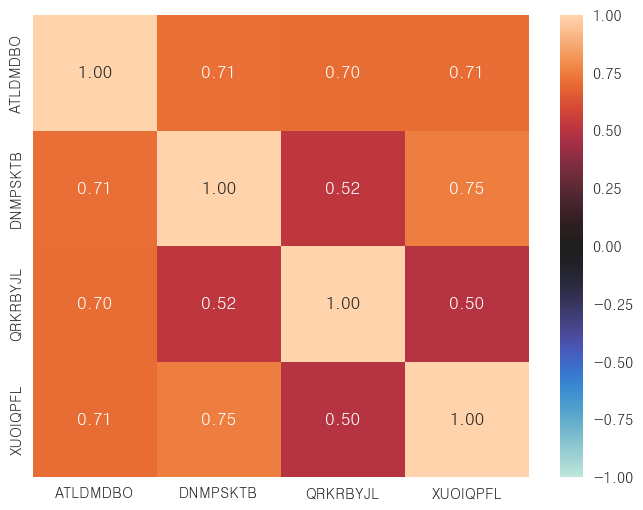

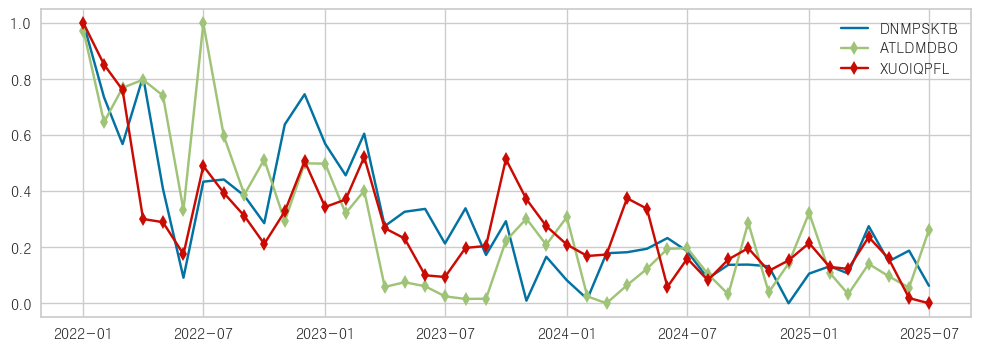

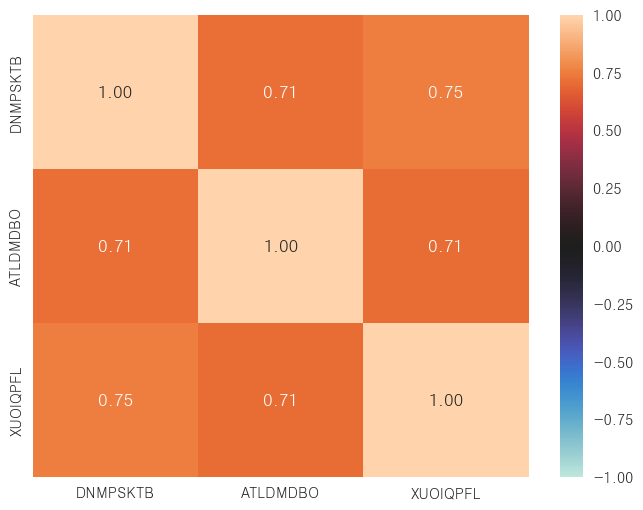

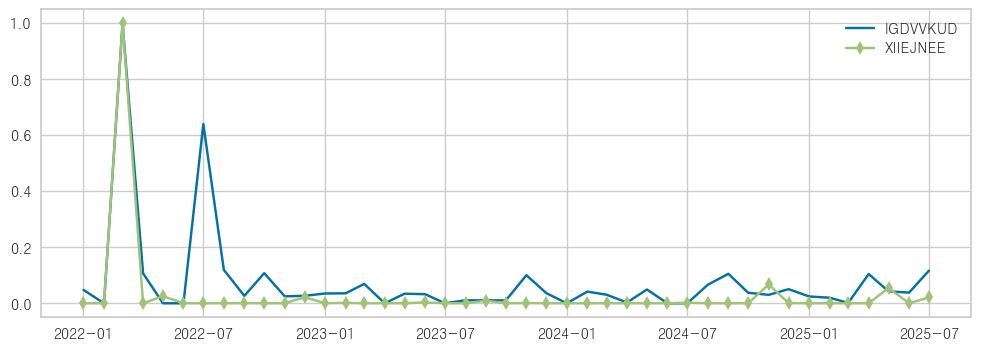

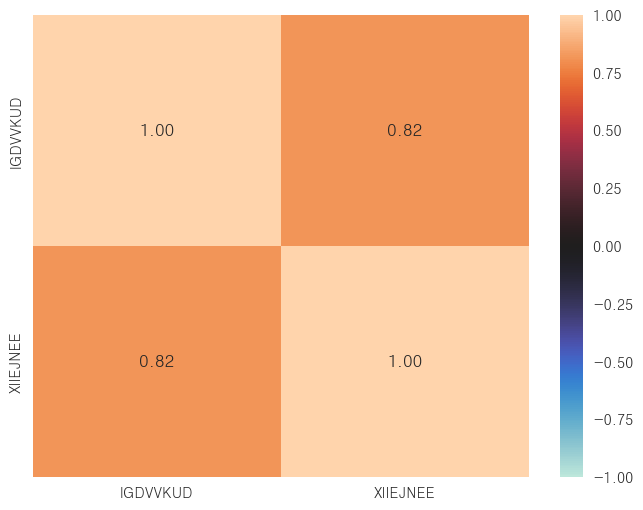

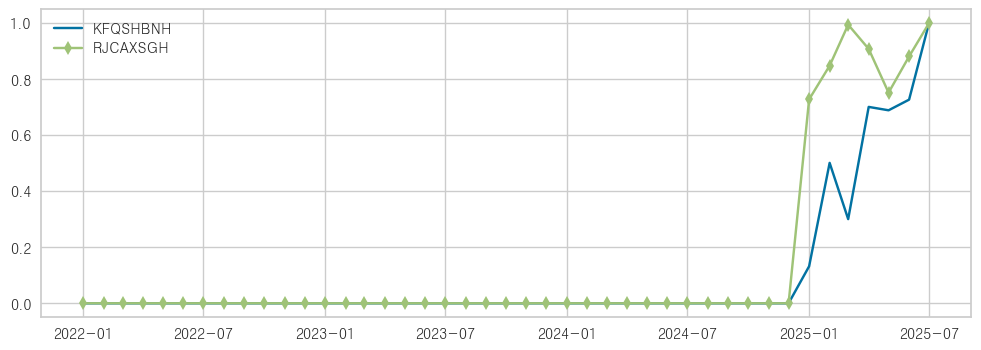

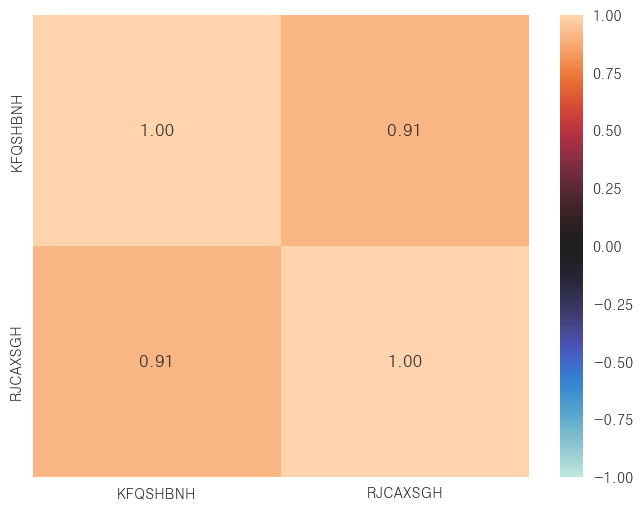

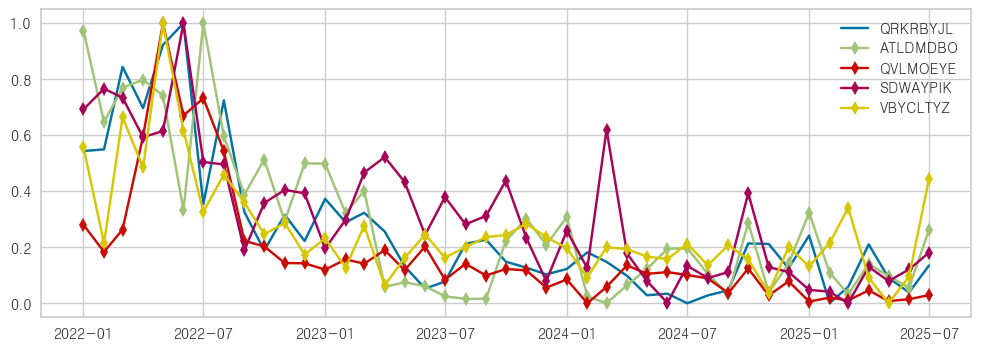

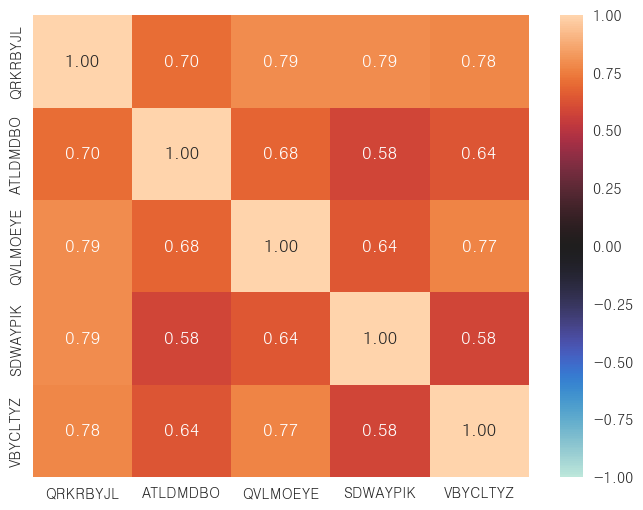

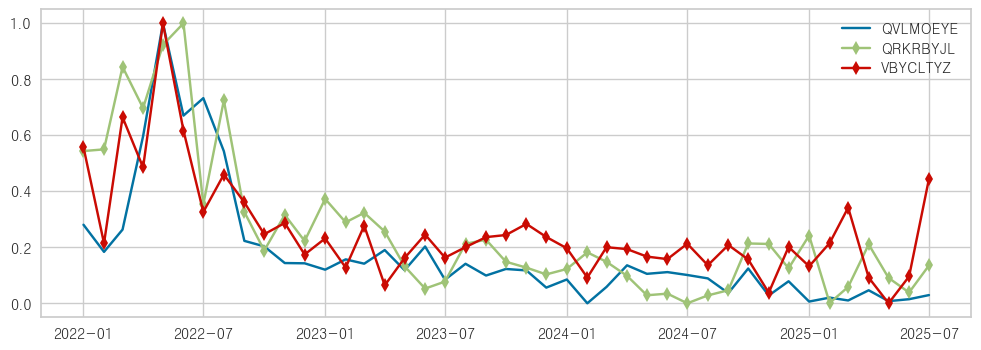

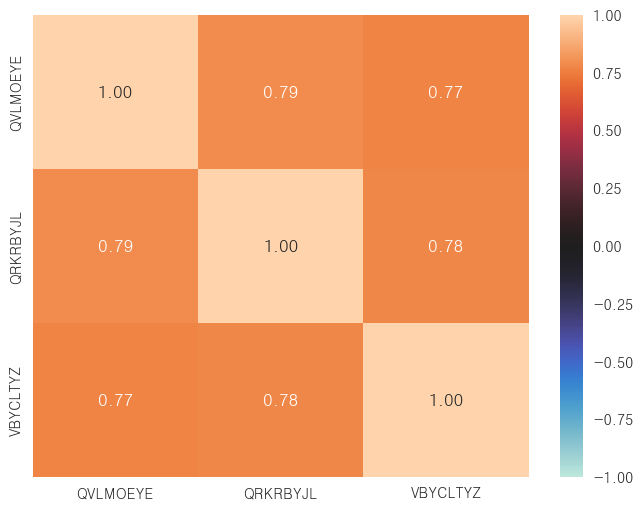

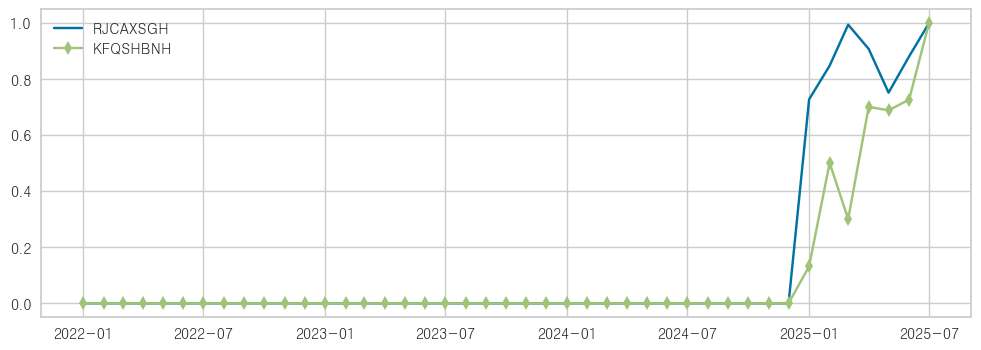

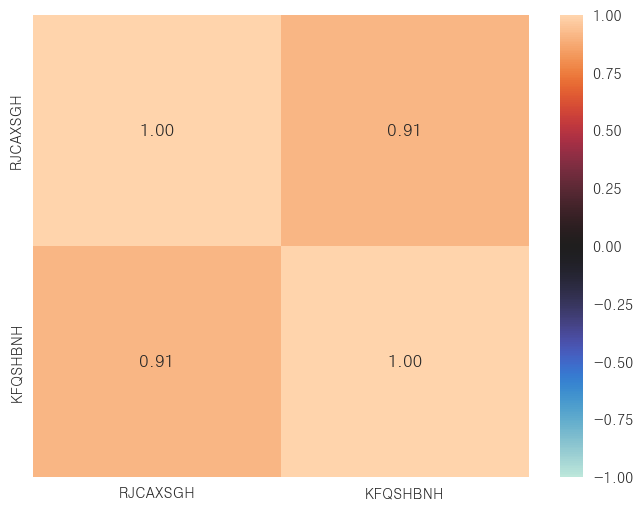

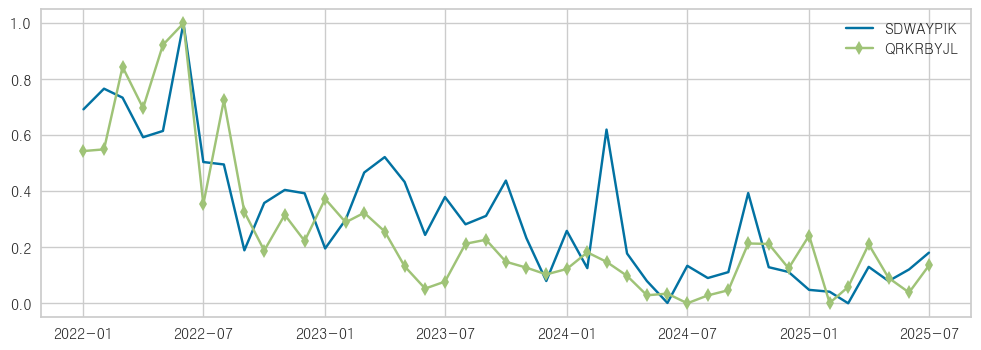

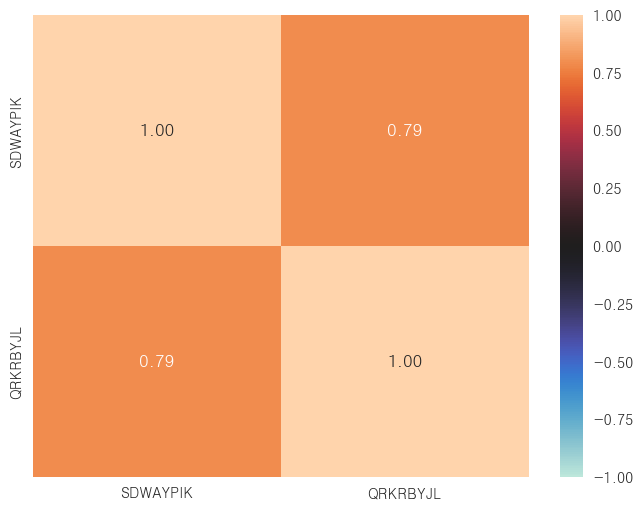

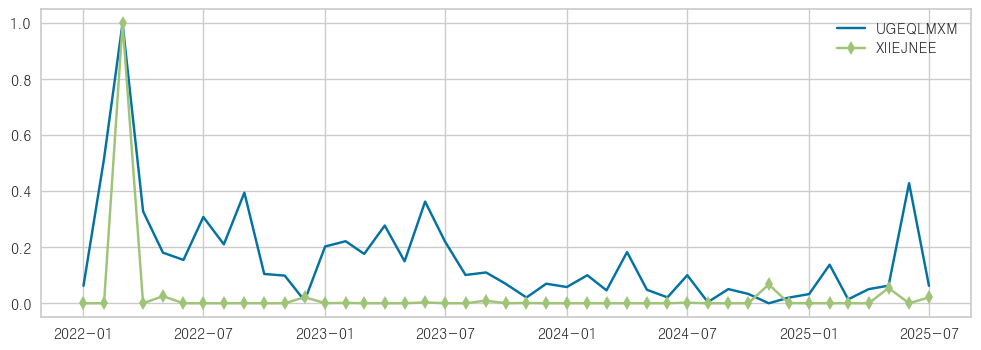

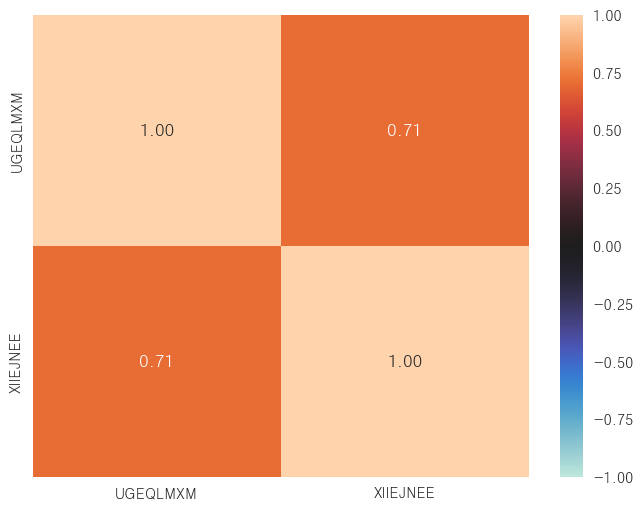

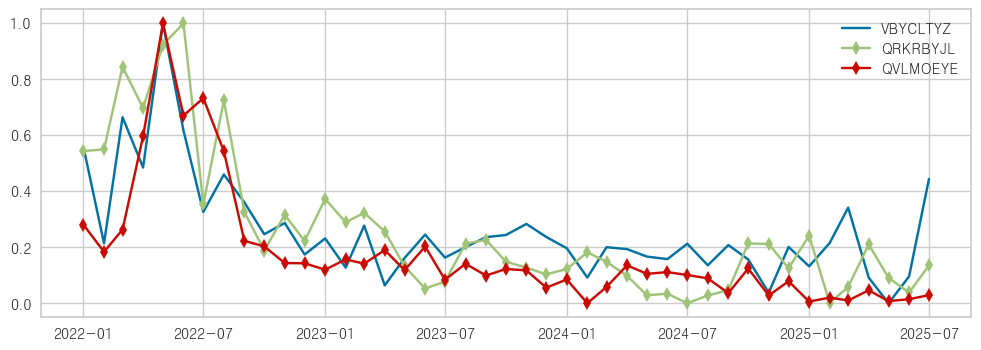

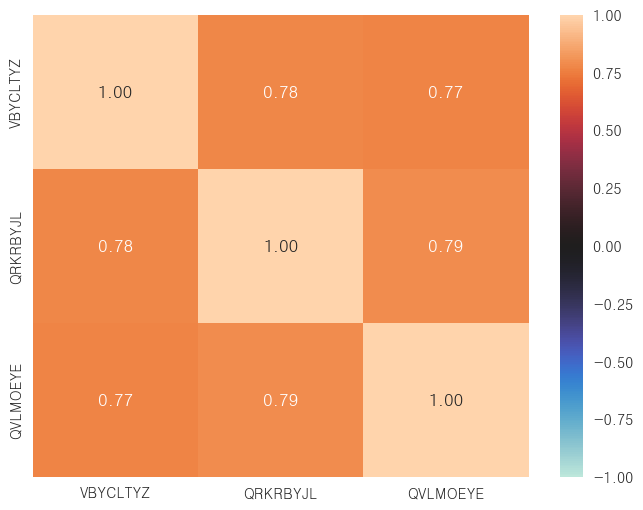

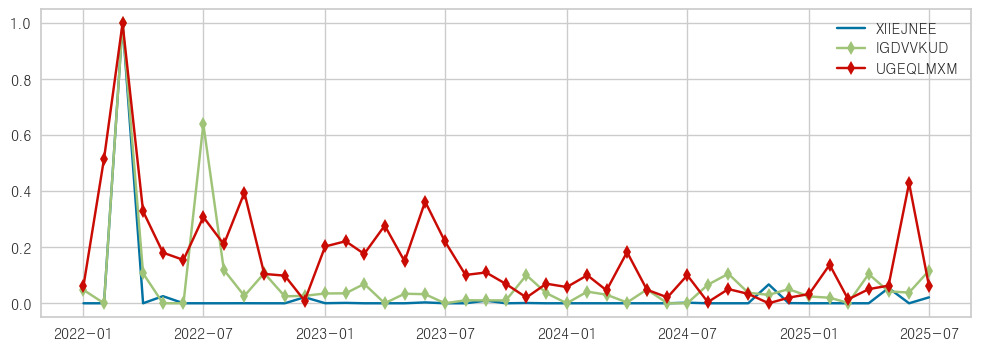

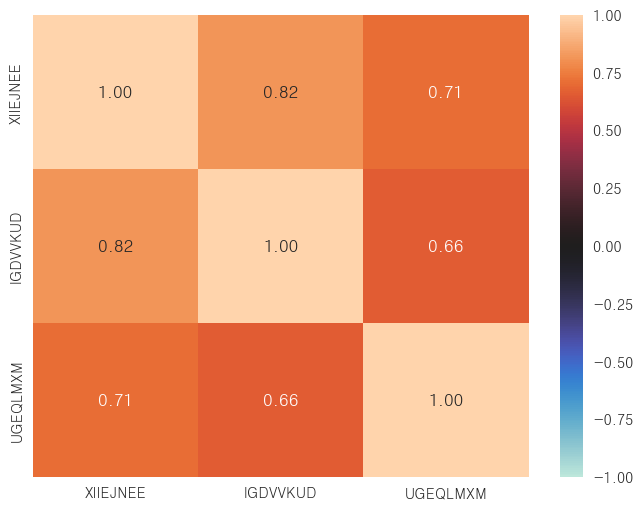

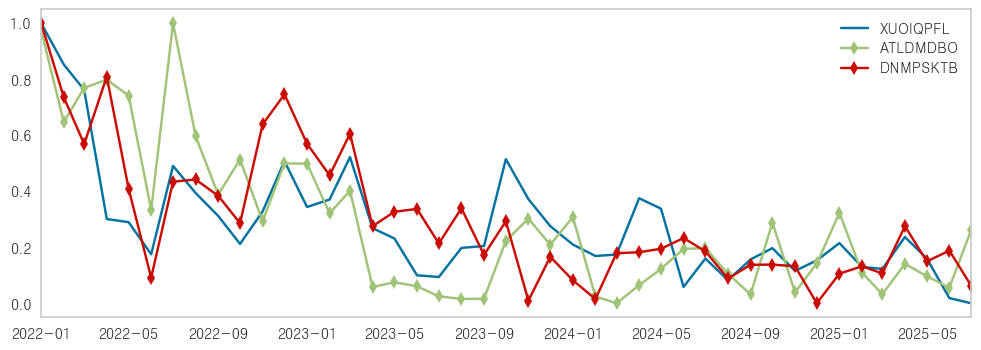

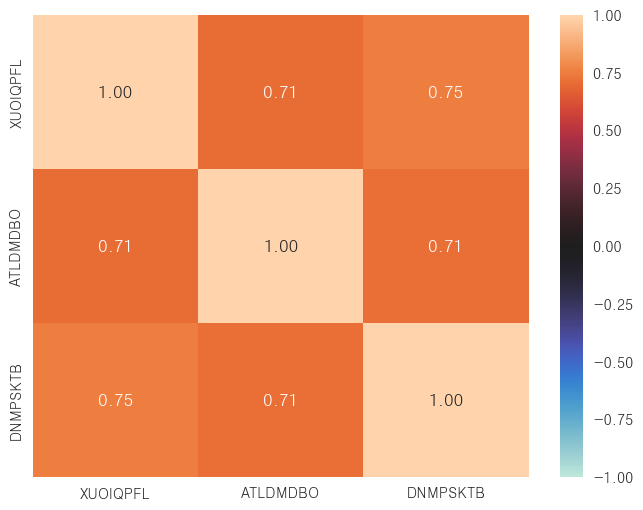

In [66]:
#///////////////////////////////////////////////////////////////
mod_dict_hight_cor = {}
# tmp_dict = {}

for i, (k, v) in enumerate(dict_hight_corr.items()):
    print(f'index = {i+1}, item, item name: {k} : {v}')
    
    fig = plt.figure(figsize=(12,4))
    df_hm_plot = pivot.loc[k].to_frame(name=k)
    ax = plt.gca()
    # 상품별 월별 무역량(월 최대 3회 교역)
    # ax.plot((pivot.loc[k] - pivot.loc[k].min()) / (pivot.loc[k].max()- pivot.loc[k].min()), label=f'key: {k}', marker='s')
    #key_name1 = f'{k}\n{hs4_name_dict.get(str(k))}'
    key_name1 = f'{k}'     

    lbl_hmap = []
    lbl_hmap.append(key_name1)
    
    ax.plot((pivot.loc[k] - pivot.loc[k].min()) / (pivot.loc[k].max()- pivot.loc[k].min()), label=key_name1)
    
    df_hm_plot = pd.concat([df_hm_plot, pivot.loc[k]], axis=0)
    #df_hm_plot[f'{k}'] = pivot_monthly[k].values
    #display(df_hm_plot.reset_index())
    
    for j, item in enumerate(v):
        #key_name2 = f'{item}\n{hs4_name_dict.get(str(item))}'
        key_name2 = f'{item}'
        lbl_hmap.append(key_name2)
        
        #ax.plot(pivot.loc[item]/pivot.loc[item].max(), label=f'item: {item}')
        ax.plot((pivot.loc[item]- pivot.loc[item].min())/(pivot.loc[item].max()- pivot.loc[item].min()), label=key_name2, marker='d')
        
        #df_hm_plot = pd.concat([df_hm_plot, pivot_monthly[item]], axis=0)
        df_hm_plot[f'{item}'] = pivot.loc[item]
    
    
    fig_sns = plt.figure(figsize=(8,6))
    
    corr_mat= df_hm_plot.corr()
    ax.legend()
    
    sns.heatmap(corr_mat, annot=True, fmt=".2f", xticklabels=lbl_hmap, yticklabels= lbl_hmap, vmin=-1, vmax=1, center=0)
    
    tmp_dict = {}
    for m, item in enumerate(dict_hight_corr[k]): # [ v1, v2]
        tmp_dict[item] = round(float(corr_mat.iloc[0, m+1]), 2)
    
    mod_dict_hight_cor[k] = tmp_dict
        
ax.set_xlim([monthly['ym'].min(), monthly['ym'].max()])
ax.grid()
plt.show()

## 년도별 군집 변화

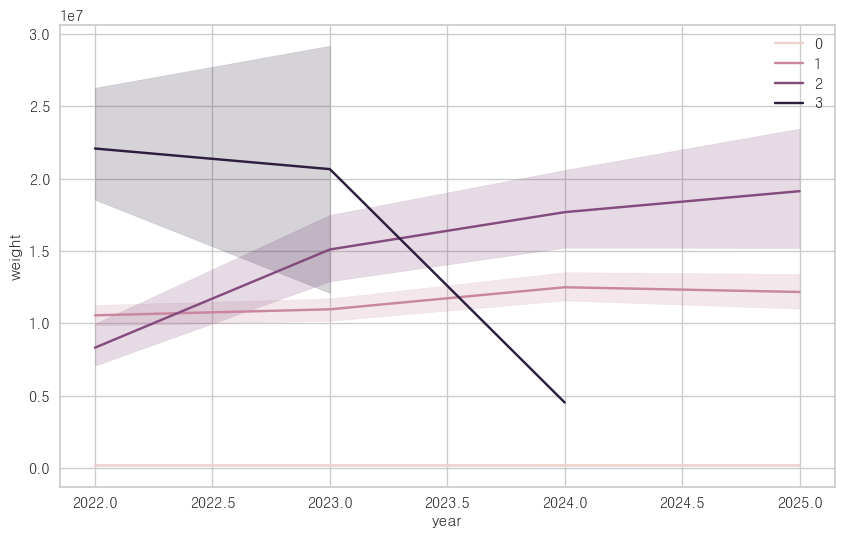

In [67]:
# 년도에 따라서 군집이 어떻게 변하는지

fig = plt.figure(figsize=(10,6))
fig.set_facecolor('white')
sns.lineplot(data=hs4_code, x='year', y='weight',
            hue='cluster_manual',
        )
plt.legend()
plt.show()




In [68]:
!pip install plotly==3.8.1
!pip install cufflinks

  Using cached plotly-3.8.1-py2.py3-none-any.whl.metadata (6.2 kB)
Using cached plotly-3.8.1-py2.py3-none-any.whl (41.2 MB)
  Attempting uninstall: plotly
    Found existing installation: plotly 6.4.0
    Uninstalling plotly-6.4.0:
      Successfully uninstalled plotly-6.4.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cufflinks 0.17.3 requires plotly>=4.1.1, but you have plotly 3.8.1 which is incompatible.


  Using cached plotly-6.4.0-py3-none-any.whl.metadata (8.5 kB)
Using cached plotly-6.4.0-py3-none-any.whl (9.9 MB)
  Attempting uninstall: plotly
    Found existing installation: plotly 3.8.1
    Uninstalling plotly-3.8.1:
      Successfully uninstalled plotly-3.8.1


### 연도별 quantity 총합 계산

In [69]:
import pandas as pd
import plotly.express as px
# 1. 연도별(year)로 quantity의 총합(sum)을 계산
df_quantity_by_year = hs4_code.groupby('year')['quantity'].sum().reset_index()

# 2. 막대 그래프로 시각화
fig = px.bar(
    df_quantity_by_year, 
    x="year", 
    y="quantity", 
    title="연도별 총 Quantity 추이"
)
fig.show()

### 월별 quantity 총합

In [70]:
# 1. 월별(month)로 quantity의 총합(sum)을 계산
df_quantity_month = hs4_code.groupby('month')['quantity'].sum().reset_index()

# 2. 막대 그래프로 시각화
fig = px.bar(
    df_quantity_month, 
    x="month", 
    y="quantity", 
    title="월별 총 Quantity 추이"
)

fig.update_traces(hovertemplate='quantity=%{y:,.0f}<br>month=%{x}<extra></extra>')
fig.show()

### 이상치 제외 후 월별 Quantity 추이

In [71]:
import pandas as pd
import plotly.express as px



threshold = 700000000


df_filtered = hs4_code[
    (hs4_code['quantity']<threshold) &
    (hs4_code['quantity']>0)
    
].copy()

# df_filtered['hs4_name'] = df_filtered['hs4_name'].astype(str)

fig = px.line(
    df_filtered, 
    x='month', 
    y='quantity', 
    color='hs4_name', 
    markers=True,
    height=1000,
    title=f"월별 Quantity 추이 (Quantity < {threshold:,} 인 데이터만 포함)"
)

fig.update_traces(hovertemplate='quantity=%{y:,.0f}<br>month=%{x}<extra></extra>')
fig.show()

